In [33]:
import pandas as pd
import glob
from IPython.display import display
import seaborn as sns
import numpy as np
import os
from scipy.stats.stats import pearsonr

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score

In [35]:
SyncCondition = pd.read_csv("SyncCondition.csv")
SyncSmokingStatus = pd.read_csv("SyncSmokingStatus.csv")
test_SyncPatient = pd.read_csv("test_SyncPatient.csv")
training_SyncAllergy = pd.read_csv("training_SyncAllergy.csv")
training_SyncDiagnosis = pd.read_csv("training_SyncDiagnosis.csv", dtype  = {'ICD9Code': str})
training_SyncImmunization = pd.read_csv("training_SyncImmunization.csv")
training_SyncLabObservation = pd.read_csv("training_SyncLabObservation.csv")
training_SyncLabPanel = pd.read_csv("training_SyncLabPanel.csv")
training_SyncLabResult = pd.read_csv("training_SyncLabResult.csv")
training_SyncMedication  = pd.read_csv("training_SyncMedication.csv")
training_SyncPatient = pd.read_csv("training_SyncPatient.csv")
training_SyncPatientCondition = pd.read_csv("training_SyncPatientCondition.csv")
training_SyncPatientSmokingStatus = pd.read_csv("training_SyncPatientSmokingStatus.csv")
training_SyncPrescription = pd.read_csv("training_SyncPrescription.csv")
training_SyncTranscript = pd.read_csv("training_SyncTranscript.csv")
training_SyncTranscriptAllergy = pd.read_csv("training_SyncTranscriptAllergy.csv")
training_SyncTranscriptDiagnosis = pd.read_csv("training_SyncTranscriptDiagnosis.csv")
training_SyncTranscriptMedication = pd.read_csv("training_SyncTranscriptMedication.csv")

# Flattening Files

The following sections are where I flatten each of the files individually and then merge them together. You can start here if you are lacking RAM/working memory. 

# Flattening Sync Diagnosis

Some of the ICD9 codes have strings that need to be replaced. 

In [36]:
training_SyncDiagnosis['ICD9Code'] = training_SyncDiagnosis['ICD9Code'].str.replace("V",'2000')
training_SyncDiagnosis['ICD9Code'] = training_SyncDiagnosis['ICD9Code'].str.replace("E",'2000')
training_SyncDiagnosis['ICD9Code'] = training_SyncDiagnosis['ICD9Code'].str.replace("v",'2000')
training_SyncDiagnosis['ICD9Code'] = training_SyncDiagnosis['ICD9Code'].str.replace("e",'2000')

In [37]:
training_SyncDiagnosis['ICD9Code'] = training_SyncDiagnosis['ICD9Code'].astype(float)

In [38]:
diagnosis_list = [0]*training_SyncDiagnosis.shape[0]
for i in range(training_SyncDiagnosis.shape[0]):
    if training_SyncDiagnosis['ICD9Code'].iloc[i] == 585.00 or training_SyncDiagnosis['ICD9Code'].iloc[i] == 276.70 or training_SyncDiagnosis['ICD9Code'].iloc[i] == 250.61:
        diagnosis_list[i] = 1
    else:
        diagnosis_list[i] = 0

In [39]:
training_SyncDiagnosis['ICD_Bucket'] = diagnosis_list

In [40]:
Final_SyncDiagnosis = training_SyncDiagnosis.pivot_table(['ICD_Bucket'],
               index = ['PatientGuid'], aggfunc='sum')

In [41]:
Final_SyncDiagnosis.reset_index(level=0, inplace=True)

The following is the end result. The buckets currently indicate how many diagnosis the patient had for the ICD 9 codes listed above. Buckets 2 and 3 are rather small so we could roll these back up into bucket 1 making it a binary indicator

In [42]:
Final_SyncDiagnosis['ICD_Bucket'].value_counts()

0    9806
1     127
2      13
3       2
Name: ICD_Bucket, dtype: int64

In [43]:
dict = {
    0:0,
 1:1,
 2:1,
 3:1
}
Final_SyncDiagnosis['ICD_Bucket'] = Final_SyncDiagnosis['ICD_Bucket'].map(dict)
Final_SyncDiagnosis['ICD_Bucket'].value_counts()

0    9806
1     142
Name: ICD_Bucket, dtype: int64

# Flattening Sync Medication

Next, merging with SyncMedication. Going to merge on DiagnosisGuid (assuming each medicine is related to a specific diagnosis). Going to not include PatientGuid (irrelevant). Was going to rename StartYear and StopYear but it appears theyve been taken out. 

In [44]:
training_SyncMedication.columns

Index(['MedicationGuid', 'PatientGuid', 'NdcCode', 'MedicationName',
       'MedicationStrength', 'Schedule', 'DiagnosisGuid', 'UserGuid'],
      dtype='object')

In [45]:
training_SyncMedication['Count'] = 1

In [46]:
training_SyncMedication = pd.crosstab(training_SyncMedication['PatientGuid'], training_SyncMedication['Count'])

In [47]:
training_SyncMedication.reset_index(level=0, inplace=True)

In [48]:
training_SyncMedication.columns = ['PatientGuid', 'Count_of_Medications']

In [49]:
training_SyncMedication.head()

,PatientGuid,Count_of_Medications
0,00023761-9D8D-445B-874C-2424CC7CF620,1
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,1
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,2
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,4
4,002667F4-B9A3-4DE2-875F-8034DD637865,1


# Flattening Sync Patient Smoking Status

In [50]:
Smoking_Merged = training_SyncPatientSmokingStatus.merge(SyncSmokingStatus, how = 'left', on = 'SmokingStatusGuid')

In [51]:
Smoking_Merged.shape

(4940, 6)

In [52]:
Smoking_Merged.sort_values(by = 'EffectiveYear', ascending = True, inplace = True) #shows that we only have
# a few 0s, not of which are duplicated. 

In [53]:
Smoking_Merged.head(5)

,PatientSmokingStatusGuid,PatientGuid,SmokingStatusGuid,EffectiveYear,Description,NISTcode
4771,5B6BE503-1EF8-4D77-8E8C-F701AF04E490,E4BBCBFE-5E18-4AC8-AB13-A82C899C45BA,FCD437AA-0451-4D8A-9396-B6F19D8B25E8,0,1-2 packs per day,1
904,0DB3517B-44EE-4BCB-AA5F-2E5EB9B49007,42AEFCAF-588F-4BA9-AD98-C21358B910E3,C12C2DB7-D31A-4514-88C0-42CBD339F764,0,0 cigarettes per day (previous smoker),3
699,1B7B3544-D2C8-4C79-9D70-23C1BFF97A09,631CD3C2-6E12-4FE1-9EB3-19086FB3FD21,5ABBAB35-836F-4F3E-8632-CE063828DA15,0,0 cigarettes per day (non-smoker or less than ...,4
4212,509495D1-FA83-4BBB-88EA-D9E56B3B06A2,1E7E90F6-0EDE-4B44-A0FB-0B9FA4CD200E,5ABBAB35-836F-4F3E-8632-CE063828DA15,1928,0 cigarettes per day (non-smoker or less than ...,4
4244,7879065D-AC40-4C33-A973-DC0DA903508C,862F8731-20B4-4653-8B70-9FE745DF1DE7,5ABBAB35-836F-4F3E-8632-CE063828DA15,1934,0 cigarettes per day (non-smoker or less than ...,4


In [54]:
new_codes = [0]*Smoking_Merged.shape[0]
for i in range(Smoking_Merged.shape[0]):
    if Smoking_Merged['Description'].iloc[i] == '2 or more packs per day' or Smoking_Merged['Description'].iloc[i] == 'Up to 1 pack per day' or Smoking_Merged['Description'].iloc[i] == '1-2 packs per day':
        new_codes[i] = 2
    elif Smoking_Merged['Description'].iloc[i] == 'Current status unknown':
        new_codes[i] = 5
    elif Smoking_Merged['Description'].iloc[i] == 'Not a current tobacco user' or Smoking_Merged['Description'].iloc[i] == '0 cigarettes per day (previous smoker)':
        new_codes[i] = 0
    elif Smoking_Merged['Description'].iloc[i] == 'Few (1-3) cigarettes per day':
        new_codes[i] = 1
    elif Smoking_Merged['Description'].iloc[i] == '0 cigarettes per day (non-smoker or less than 100 in lifetime)':
        new_codes[i] = 3
    else:
        new_codes[i] = 4
Smoking_Merged['new_codes'] = new_codes

In [55]:
Smoking_Merged.drop_duplicates(subset = 'PatientGuid', keep = 'last', inplace = True)

In [56]:
Smoking_Merged[Smoking_Merged['new_codes']==3]['EffectiveYear'].value_counts()

2011    1232
2012     644
2010       7
2009       4
2005       1
1998       1
1981       1
1979       1
1970       1
1956       1
1937       1
1934       1
1928       1
0          1
Name: EffectiveYear, dtype: int64

# Flattening Sync Transcript

In [57]:
training_SyncTranscript.isnull().sum()/training_SyncTranscript.shape[0] 

TranscriptGuid        0.000000
PatientGuid           0.000000
VisitYear             0.000000
Height                0.541727
Weight                0.000000
BMI                   0.000000
SystolicBP            0.346872
DiastolicBP           0.346872
RespiratoryRate       0.609314
HeartRate             1.000000
Temperature           0.618151
PhysicianSpecialty    0.001381
UserGuid              0.000000
dtype: float64

In [58]:
training_SyncTranscript.sort_values(by = 'VisitYear', ascending = True, inplace = True)

In [59]:
training_SyncTranscript.drop_duplicates(subset = 'PatientGuid', keep = 'last', inplace = True)

In [60]:
training_SyncTranscript.shape

(9948, 13)

It was possible that deleting duplicates in this case would result in the loss of information, aka more nulls, quick check is showing a decrease in nulls. 

In [61]:
training_SyncTranscript.isnull().sum()/training_SyncTranscript.shape[0] 

TranscriptGuid        0.000000
PatientGuid           0.000000
VisitYear             0.000000
Height                0.396361
Weight                0.000000
BMI                   0.000000
SystolicBP            0.238138
DiastolicBP           0.238138
RespiratoryRate       0.547849
HeartRate             1.000000
Temperature           0.537998
PhysicianSpecialty    0.001809
UserGuid              0.000000
dtype: float64

In [62]:
training_SyncTranscript.columns

Index(['TranscriptGuid', 'PatientGuid', 'VisitYear', 'Height', 'Weight', 'BMI',
       'SystolicBP', 'DiastolicBP', 'RespiratoryRate', 'HeartRate',
       'Temperature', 'PhysicianSpecialty', 'UserGuid'],
      dtype='object')

In [63]:
comorbidity_list = [0]*training_SyncTranscript.shape[0]
for i in range(training_SyncTranscript.shape[0]):
    if training_SyncTranscript['PhysicianSpecialty'].iloc[i] == 'Physical Medicine & Rehabilitation' or training_SyncTranscript['PhysicianSpecialty'].iloc[i] == 'Nephrology' or training_SyncTranscript['PhysicianSpecialty'].iloc[i] == 'Pulmonary Disease' or training_SyncTranscript['PhysicianSpecialty'].iloc[i] == 'Endocrinology; Diabetes; & Metabolism' or training_SyncTranscript['PhysicianSpecialty'].iloc[i] == 'Rheumatology' :
        comorbidity_list[i] = 1
    else:
        comorbidity_list[i] = 0

In [64]:
training_SyncTranscript['Comorbidity'] = comorbidity_list

Now, going to impute values. There doesn't seem to be a very good method due to the high volume of missing values. Going to merge in age/gender and impute values with the average for said population. 

In [65]:
Transcript = training_SyncTranscript.merge(test_SyncPatient[{'PatientGuid','Gender','YearOfBirth'}], how = 'left', on = 'PatientGuid')

In [66]:
Transcript['Age'] = 2019 - Transcript['YearOfBirth']

In [67]:
Transcript[{'Age','YearOfBirth'}].head(10)

,YearOfBirth,Age
0,1948,71
1,1953,66
2,1958,61
3,1972,47
4,1961,58
5,1940,79
6,1982,37
7,1948,71
8,1922,97
9,1961,58


Taking a look at age to determine the min and max age. Next will be creating buckets and then dictionaries that contain the average BMI, weight, etc for every gender/age combination. This dictionary will then be used in a for loop to fill in any values that are either NaN or 0. 

In [68]:
Transcript['Age'].min()

25

In [69]:
Transcript['Age'].max()

97

In [70]:
bins = [0,30,35,39,45,49,55,59,65,69,75,79,85,89, np.inf]
names = ['<30', '30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90+']
Transcript['Age_Range'] = pd.cut(Transcript['Age'], bins, labels=names)

In [71]:
Transcript_Male = Transcript[Transcript['Gender']=='M']
Transcript_Female = Transcript[Transcript['Gender']=='F']

In [72]:
BMI_Male = Transcript_Male[Transcript_Male['BMI'].notnull()].pivot_table(['BMI'],index = ['Age_Range'], aggfunc='mean')
BMI_Male_dict = BMI_Male.T.to_dict('records')

BMI_Female = Transcript_Female[Transcript_Female['BMI'].notnull()].pivot_table(['BMI'],index = ['Age_Range'], aggfunc='mean')
BMI_Female_dict = BMI_Male.T.to_dict('records')

Weight_Male = Transcript_Male[Transcript_Male['Weight'].notnull()].pivot_table(['Weight'],index = ['Age_Range'], aggfunc='mean')
Weight_Male_dict = BMI_Male.T.to_dict('records')

Weight_Female = Transcript_Female[Transcript_Female['Weight'].notnull()].pivot_table(['Weight'],index = ['Age_Range'], aggfunc='mean')
Weight_Female_dict = BMI_Male.T.to_dict('records')

SystolicBP_Male = Transcript_Male[Transcript_Male['SystolicBP'].notnull()].pivot_table(['SystolicBP'],index = ['Age_Range'], aggfunc='mean')
SystolicBP_Male_dict = BMI_Male.T.to_dict('records')

DiastolicBP_Male = Transcript_Male[Transcript_Male['DiastolicBP'].notnull()].pivot_table(['DiastolicBP'],index = ['Age_Range'], aggfunc='mean')
DiastolicBP_Male_dict = BMI_Male.T.to_dict('records')

SystolicBP_Female = Transcript_Female[Transcript_Female['SystolicBP'].notnull()].pivot_table(['SystolicBP'],index = ['Age_Range'], aggfunc='mean')
SystolicBP_Female_dict = BMI_Male.T.to_dict('records')

DiastolicBP_Female = Transcript_Female[Transcript_Female['DiastolicBP'].notnull()].pivot_table(['DiastolicBP'],index = ['Age_Range'], aggfunc='mean')
DiastolicBP_Female_dict = BMI_Male.T.to_dict('records')

In [73]:
new_bmi = [0]*Transcript.shape[0]
new_weight = [0]*Transcript.shape[0]
new_Diastolic = [0]*Transcript.shape[0]
new_Systolic = [0]*Transcript.shape[0]

In [74]:
for i in range(Transcript.shape[0]):
    if (pd.isnull(Transcript['Weight'].iloc[i])) or (Transcript['Weight'].iloc[i] == 0):
        if Transcript['Gender'].iloc[i] == 'M':
            new_weight[i] = Weight_Male_dict[0].get(Transcript['Age_Range'].iloc[i])
        else:
            new_weight[i] = Weight_Female_dict[0].get(Transcript['Age_Range'].iloc[i])
    else:
        new_weight[i] = Transcript['Weight'].iloc[i]

In [75]:
for i in range(Transcript.shape[0]):
    if pd.isnull(Transcript['BMI'].iloc[i]) or Transcript['BMI'].iloc[i] == 0:
        if Transcript['Gender'].iloc[i] == 'M':
            new_bmi[i] = BMI_Male_dict[0].get(Transcript['Age_Range'].iloc[i])
        else:
            new_bmi[i] = BMI_Female_dict[0].get(Transcript['Age_Range'].iloc[i])
    else:
        new_bmi[i] = Transcript['BMI'].iloc[i]

In [76]:
for i in range(Transcript.shape[0]):
    if pd.isnull(Transcript['DiastolicBP'].iloc[i]) or Transcript['DiastolicBP'].iloc[i] == 0:
        if Transcript['Gender'].iloc[i] == 'M':
            new_Diastolic[i] = DiastolicBP_Male_dict[0].get(Transcript['Age_Range'].iloc[i])
        else:
            new_Diastolic[i] = DiastolicBP_Female_dict[0].get(Transcript['Age_Range'].iloc[i])
    else:
        new_Diastolic[i] = Transcript['DiastolicBP'].iloc[i]

In [77]:
for i in range(Transcript.shape[0]):
    if pd.isnull(Transcript['SystolicBP'].iloc[i]) or Transcript['SystolicBP'].iloc[i] == 0:
        if Transcript['Gender'].iloc[i] == 'M':
            new_Systolic[i] = SystolicBP_Male_dict[0].get(Transcript['Age_Range'].iloc[i])
        else:
            new_Systolic[i] = SystolicBP_Female_dict[0].get(Transcript['Age_Range'].iloc[i])
    else:
        new_Systolic[i] = Transcript['SystolicBP'].iloc[i]

In [78]:
Transcript['New_BMI'] = new_bmi
Transcript['New_Weight'] = new_weight
Transcript['New_DiastolicBP'] = new_Diastolic
Transcript['New_SystolicBP'] = new_Systolic

In [79]:
Transcript.columns

Index(['TranscriptGuid', 'PatientGuid', 'VisitYear', 'Height', 'Weight', 'BMI',
       'SystolicBP', 'DiastolicBP', 'RespiratoryRate', 'HeartRate',
       'Temperature', 'PhysicianSpecialty', 'UserGuid', 'Comorbidity',
       'YearOfBirth', 'Gender', 'Age', 'Age_Range', 'New_BMI', 'New_Weight',
       'New_DiastolicBP', 'New_SystolicBP'],
      dtype='object')

Filling in the Nulls for Height now. Since height likely doesn't change much from 25+ (likely some decrease when you're older but otherwise should be fairly consistent), going to fill in the average height for gender. 

In [80]:
average_height_male = Transcript[(Transcript['Height'].notnull()) & (Transcript['Gender']=='M')]['Height'].mean()
average_height_female = Transcript[(Transcript['Height'].notnull()) & (Transcript['Gender']=='F')]['Height'].mean()

In [81]:
print("average height of males is...",average_height_male)
print("average height of females is...",average_height_female)

average height of males is... 69.06996321321321
average height of females is... 63.44830589643816


In [82]:
TM = Transcript[Transcript['Gender']=='M'].copy()
TF = Transcript[Transcript['Gender']=='F'].copy()

In [83]:
TM['Height'].fillna(value=average_height_male, inplace = True)
TF['Height'].fillna(value=average_height_female, inplace = True)

In [84]:
Transcript_Final = pd.concat([TM,TF])

In [85]:
Transcript_Final.drop(['BMI','Weight','DiastolicBP','SystolicBP','Age','Gender','YearOfBirth'], axis = 1, inplace = True)

In [86]:
Transcript_Final.rename(columns = {'New_BMI':'BMI','New_Weight':'Weight','New_DiastolicBP':'DiastolicBP','New_SystolicBP':'SystolicBP'}, inplace = True)

In [87]:
Transcript_Final.isnull().sum() # we will not be using respitoryrate, heartrate, or temperature this time around. 

TranscriptGuid           0
PatientGuid              0
VisitYear                0
Height                   0
RespiratoryRate       5450
HeartRate             9948
Temperature           5352
PhysicianSpecialty      18
UserGuid                 0
Comorbidity              0
Age_Range                0
BMI                      0
Weight                   0
DiastolicBP              0
SystolicBP               0
dtype: int64

Now, merging in all of the files into one. 

In [88]:
train_test_SyncPatient = test_SyncPatient.merge(training_SyncPatient[{'PatientGuid','DMIndicator'}], how = 'left', on = 'PatientGuid')

In [89]:
SP_SD = train_test_SyncPatient.merge(Final_SyncDiagnosis, how = 'left',on = 'PatientGuid')

In [90]:
SP_SD.shape

(9948, 7)

In [91]:
SP_SD_SM = SP_SD.merge(training_SyncMedication, how = 'left', on ='PatientGuid')

In [92]:
SP_SD_SM.shape

(9948, 8)

In [93]:
Transcript_Final.columns

Index(['TranscriptGuid', 'PatientGuid', 'VisitYear', 'Height',
       'RespiratoryRate', 'HeartRate', 'Temperature', 'PhysicianSpecialty',
       'UserGuid', 'Comorbidity', 'Age_Range', 'BMI', 'Weight', 'DiastolicBP',
       'SystolicBP'],
      dtype='object')

In [94]:
SP_SD_SM_SS = SP_SD_SM.merge(Smoking_Merged[{'PatientGuid','EffectiveYear','new_codes'}], how = 'left',on = 'PatientGuid')

In [95]:
SP_SD_SM_SS.shape

(9948, 10)

In [96]:
SP_SD_SM_SS_T = SP_SD_SM_SS.merge(Transcript_Final[{'PatientGuid','Height','BMI','Weight','DiastolicBP','SystolicBP','Comorbidity'}], how = 'left', on ='PatientGuid')

In [97]:
SP_SD_SM_SS_T.shape

(9948, 16)

Final round of imputation, cleaning, and feature engineering

In [98]:
SP_SD_SM_SS_T.isnull().sum()

PatientGuid                0
Gender                     0
YearOfBirth                0
State                      0
PracticeGuid               0
DMIndicator             3348
ICD_Bucket                 0
Count_of_Medications     102
EffectiveYear           5521
new_codes               5521
BMI                        0
DiastolicBP                0
SystolicBP                 0
Height                     0
Weight                     0
Comorbidity                0
dtype: int64

New codes is the redone smoking status bucketing/grouping. Thus if we do not know their status, going to lump these into the unknown category with the tohers. 

In [99]:
SP_SD_SM_SS_T['new_codes'].fillna(value=5, inplace = True)

Not too many NANs within the medications, going to fill this in with median. 

In [100]:
SP_SD_SM_SS_T['Count_of_Medications'].median()

3.0

In [101]:
SP_SD_SM_SS_T['Count_of_Medications'].fillna(value=3, inplace = True)

In [102]:
SP_SD_SM_SS_T.columns

Index(['PatientGuid', 'Gender', 'YearOfBirth', 'State', 'PracticeGuid',
       'DMIndicator', 'ICD_Bucket', 'Count_of_Medications', 'EffectiveYear',
       'new_codes', 'BMI', 'DiastolicBP', 'SystolicBP', 'Height', 'Weight',
       'Comorbidity'],
      dtype='object')

Lastly, some regions of the country have higher instances of obesity and diabetes. Grouping these together

In [103]:
def region(State):
    if State == 'CT' or State == 'ME' or State == 'MA' or State == 'NH' or State == 'RI' or State == 'VT' or State == 'NJ' or State == 'NY' or State == 'PA':
        return 0
    elif State == 'IL' or State == 'IN' or State == 'MI' or State == 'OH' or State == 'WI' or State == 'IA' or State == 'KS' or State == 'MN' or State == 'MO' or State == 'NE' or State == 'ND' or State == 'SD':
        return 1
    elif State == 'AZ' or State == 'CO' or State == 'ID' or State == 'MT' or State == 'NV' or State == 'NM' or State == 'UT' or State == 'WY' or State == 'AK' or State == 'CA' or State == 'HI' or State == 'OR' or State == 'WA':
        return 2
    elif State == 'DE' or State == 'FL' or State == 'GA' or State == 'MD' or State == 'NC' or State == 'SC' or State == 'VA' or State == 'DC' or State == 'WV' or State == 'AL' or State == 'KY' or State == 'MS' or State == 'TN' or State == 'AR' or State == 'OK' or State == 'TX' or State == 'LA':
        return 3
    else:
        return 4

In [104]:
Region = [ region(State) for State in SP_SD_SM_SS_T.State]

In [105]:
SP_SD_SM_SS_T['Region'] = Region

In [106]:
SP_SD_SM_SS_T.columns

Index(['PatientGuid', 'Gender', 'YearOfBirth', 'State', 'PracticeGuid',
       'DMIndicator', 'ICD_Bucket', 'Count_of_Medications', 'EffectiveYear',
       'new_codes', 'BMI', 'DiastolicBP', 'SystolicBP', 'Height', 'Weight',
       'Comorbidity', 'Region'],
      dtype='object')

In [107]:
SP_SD_SM_SS_T['Age'] = 2019 - SP_SD_SM_SS_T['YearOfBirth']

In [108]:
bins = [0,49,57,np.inf]
names = [0,1,2]
SP_SD_SM_SS_T['Age_Bucket'] = pd.cut(SP_SD_SM_SS_T['Age'], bins, labels=names)

In [109]:
class_le = LabelEncoder()
SP_SD_SM_SS_T['Gender_New'] = class_le.fit_transform(SP_SD_SM_SS_T['Gender'])

In [110]:
SP_SD_SM_SS_T.drop(['EffectiveYear','State','Age','YearOfBirth','Gender','PracticeGuid'], axis = 1, inplace = True)

In [111]:
SP_SD_SM_SS_T.rename(columns = {'Gender_New':'Gender','new_codes':'RE_NISTcode'},inplace = True)

In [112]:
SP_SD_SM_SS_T.columns

Index(['PatientGuid', 'DMIndicator', 'ICD_Bucket', 'Count_of_Medications',
       'RE_NISTcode', 'BMI', 'DiastolicBP', 'SystolicBP', 'Height', 'Weight',
       'Comorbidity', 'Region', 'Age_Bucket', 'Gender'],
      dtype='object')

In [113]:
SP_SD_SM_SS_T.isnull().sum()

PatientGuid                0
DMIndicator             3348
ICD_Bucket                 0
Count_of_Medications       0
RE_NISTcode                0
BMI                        0
DiastolicBP                0
SystolicBP                 0
Height                     0
Weight                     0
Comorbidity                0
Region                     0
Age_Bucket                 0
Gender                     0
dtype: int64

# Modeling

Now, splitting data up into our train and test sets. Do note that we did not use one hot encoding as the first model we are running is random forest. For our metrics, note that we will be taking a look at precision, recall, and f1 score to determine what model we want to use. Then, we will take a look at brier score in order to calibrate our model. 

In [114]:
train = SP_SD_SM_SS_T[SP_SD_SM_SS_T['DMIndicator'].notnull()]
test = SP_SD_SM_SS_T[SP_SD_SM_SS_T['DMIndicator'].isnull()]

In [115]:
train.shape

(6600, 14)

In [116]:
test.shape

(3348, 14)

In [117]:
# Separate input features (X) and target variable (y)
y = train['DMIndicator']
x = train.drop(columns = ['DMIndicator','PatientGuid'], axis=1)
x_cols = x.columns

In [118]:
scaler = StandardScaler() #scaling our features due to various ranges
x = scaler.fit_transform(x)

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 1)

In [120]:
model_for = RandomForestClassifier()

#fit model
model_for.fit(x_train, y_train)

#create predictions based on model
y_pred_for = model_for.predict(x_test)

Due to the class imbalance, our model is excellent at predicting the 0 class but pretty bad at predicting 1s. Undersampling and oversampling techniques such as SMOTE and nearmiss would be beneficial. 

In [121]:
print(metrics.classification_report(y_test, y_pred_for))

              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88      1334
         1.0       0.39      0.14      0.20       316

    accuracy                           0.79      1650
   macro avg       0.61      0.54      0.54      1650
weighted avg       0.74      0.79      0.75      1650



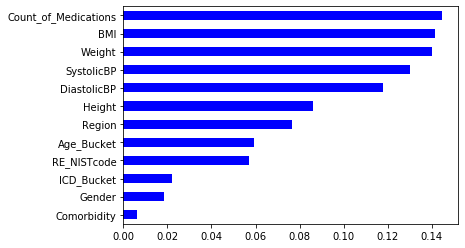

In [122]:
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances_random_forest = pd.Series(model_for.feature_importances_,
index = x_cols)
# Sort importances_rf
sorted_importances_random_forest = importances_random_forest.sort_values()
# Make a horizontal bar plot
sorted_importances_random_forest.plot(kind='barh', color='blue')
plt.show()

In [123]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

Using TensorFlow backend.


In [124]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 1)

In [125]:
smt = SMOTE()
x_train, y_train = smt.fit_sample(x_train, y_train)
np.bincount(y_train)

array([4000, 4000], dtype=int64)

In [126]:
model_for = RandomForestClassifier()

#fit model
model_for.fit(x_train, y_train)

#create predictions based on model
y_pred_for = model_for.predict(x_test)

In [127]:
print(metrics.classification_report(y_test, y_pred_for))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      1334
         1.0       0.36      0.29      0.32       316

    accuracy                           0.76      1650
   macro avg       0.60      0.58      0.59      1650
weighted avg       0.75      0.76      0.76      1650



In [128]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 1)

In [129]:
nr = NearMiss()
x_train, y_train = nr.fit_sample(x_train, y_train)
np.bincount(y_train)

array([950, 950], dtype=int64)

In [130]:
model_for = RandomForestClassifier()

#fit model
model_for.fit(x_train, y_train)

#create predictions based on model
y_pred_for = model_for.predict(x_test)

In [131]:
print(metrics.classification_report(y_test, y_pred_for))

              precision    recall  f1-score   support

         0.0       0.82      0.33      0.47      1334
         1.0       0.20      0.70      0.31       316

    accuracy                           0.40      1650
   macro avg       0.51      0.52      0.39      1650
weighted avg       0.71      0.40      0.44      1650



Going to one hot encode now and run other models. 

In [132]:
SP_SD_SM_SS_T.columns

Index(['PatientGuid', 'DMIndicator', 'ICD_Bucket', 'Count_of_Medications',
       'RE_NISTcode', 'BMI', 'DiastolicBP', 'SystolicBP', 'Height', 'Weight',
       'Comorbidity', 'Region', 'Age_Bucket', 'Gender'],
      dtype='object')

In [133]:
SP_SD_SM_SS_T = pd.concat([SP_SD_SM_SS_T,pd.get_dummies(SP_SD_SM_SS_T['Region'], prefix='Region',dummy_na=False)],axis=1).drop(['Region'],axis=1)

In [134]:
SP_SD_SM_SS_T = pd.concat([SP_SD_SM_SS_T,pd.get_dummies(SP_SD_SM_SS_T['RE_NISTcode'], prefix='RE_NISTcode',dummy_na=False)],axis=1).drop(['RE_NISTcode'],axis=1)

In [135]:
train = SP_SD_SM_SS_T[SP_SD_SM_SS_T['DMIndicator'].notnull()]
test = SP_SD_SM_SS_T[SP_SD_SM_SS_T['DMIndicator'].isnull()]

In [136]:
train.shape

(6600, 23)

In [137]:
test.shape

(3348, 23)

In [138]:
# Separate input features (X) and target variable (y)
y = train['DMIndicator']
x = train.drop(columns = ['DMIndicator','PatientGuid'], axis=1)
x_cols = x.columns

In [139]:
scaler = StandardScaler() #scaling our features due to various ranges
x = scaler.fit_transform(x)

In [140]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 1)

In [141]:
# Train model
#create the model
model = LogisticRegression()

#fit model
model.fit(x_train, y_train)

#create predictions based on model
y_pred = model.predict(x_test)

In [142]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90      1334
         1.0       0.68      0.07      0.13       316

    accuracy                           0.82      1650
   macro avg       0.75      0.53      0.51      1650
weighted avg       0.79      0.82      0.75      1650



Now, trying under and over sampling techniques due to the class imbalance. 

In [143]:
smt = SMOTE()
x_train, y_train = smt.fit_sample(x_train, y_train)
np.bincount(y_train)

array([4000, 4000], dtype=int64)

In [144]:
# Train model
#create the model
model = LogisticRegression()

#fit model
model.fit(x_train, y_train)

#create predictions based on model
y_pred = model.predict(x_test)

In [145]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.59      0.72      1334
         1.0       0.31      0.78      0.45       316

    accuracy                           0.63      1650
   macro avg       0.62      0.69      0.58      1650
weighted avg       0.80      0.63      0.67      1650



In [146]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 1)

In [147]:
nr = NearMiss()
x_train, y_train = nr.fit_sample(x_train, y_train)

In [148]:
# Train model
#create the model
model = LogisticRegression()

#fit model
model.fit(x_train, y_train)

#create predictions based on model
y_pred = model.predict(x_test)

In [149]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.45      0.59      1334
         1.0       0.21      0.63      0.32       316

    accuracy                           0.48      1650
   macro avg       0.52      0.54      0.45      1650
weighted avg       0.72      0.48      0.53      1650



Looking at brier score metrics for both of our models

In [150]:
# Compute the array containing the 10-folds CV MSEs
Brier_CV_scores = - cross_val_score(model, x_train, y_train, cv=10, 
                                  scoring='neg_brier_score', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
Mean_Brier_CV = Brier_CV_scores.mean()

# Print RMSE_CV
print('CV Brier: {:.2f}'.format(Mean_Brier_CV))

CV Brier: 0.19


In [151]:
Brier_CV_scores

array([0.13381504, 0.13709986, 0.15151022, 0.18521114, 0.18987143,
       0.21817967, 0.22172864, 0.22628793, 0.22482221, 0.23906201])

In [152]:
# Compute the array containing the 10-folds CV MSEs
Brier_CV_scores = - cross_val_score(model_for, x_train, y_train, cv=10, 
                                  scoring='neg_brier_score', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
Mean_Brier_CV = Brier_CV_scores.mean()

# Print RMSE_CV
print('CV Brier: {:.2f}'.format(Mean_Brier_CV))

CV Brier: 0.23


In [153]:
Brier_CV_scores

array([0.33768964, 0.24532132, 0.2289244 , 0.19836971, 0.18885553,
       0.20495923, 0.23991375, 0.20705054, 0.22580953, 0.23742202])